### Two datasets with a similar motif

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import mubind as mb
import numpy as np
import pandas as pd

import torch
import torch.optim as topti
import torch.utils.data as tdata

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


## I Only HT-SELEX batches

In [179]:
train, test = mb.tl.create_multi_data(n_chip=0, n_selex=300, n_batch_selex=6) # , n_selex=100)

max seqlen 14


### Using cooptf/screr (this will be deprecated and replace by bindome).

### If treating y data as log, the convergence gets to the GATA motif in small sequences.

In [180]:
train.dataset.target[train.dataset.is_count_data == 1] = np.log(train.dataset.target[train.dataset.is_count_data == 1])

In [181]:
pd.Series(train.dataset.batch).value_counts()

2_selex    63
0_selex    53
4_selex    52
1_selex    47
3_selex    43
5_selex    36
dtype: int64

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

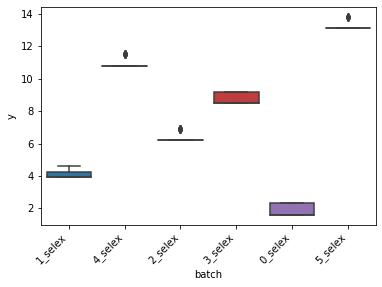

In [183]:
df = pd.DataFrame()
df['y'] = train.dataset.target
df['batch'] = np.array(train.dataset.batch)
sns.boxplot(data=df, x='batch', y='y')
plt.xticks(rotation=45, ha='right');

In [184]:
df.sort_values('y', ascending=False).head()

,y,batch
54,13.815511,5_selex
7,13.815511,5_selex
22,13.815511,5_selex
21,13.815511,5_selex
66,13.815511,5_selex


In [185]:
n_datasets = np.unique(df['batch']).shape[0]
n_latent = 3
print('# datasets', n_datasets)
print('# latent dimensions', n_latent)

# datasets 6
# latent dimensions 3


In [186]:
model = mb.models.DinucMulti(use_dinuc=True, n_datasets=n_datasets, n_latent=n_latent, w=8).to(device)
model.embedding.weight.data.uniform_(1, 1) # initialize weights as ones.
l2 = []

In [187]:
train.dataset

In [188]:
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = mb.tl.MultiDatasetLoss()
l2 += mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=2000, log_each=100)

Epoch:  1, Loss: 13.727
Epoch: 101, Loss: 0.702
Epoch: 201, Loss: 0.575
Epoch: 301, Loss: 0.616
Epoch: 401, Loss: 0.576
Epoch: 501, Loss: 0.586
Epoch: 601, Loss: 0.550
Epoch: 701, Loss: 0.578
Epoch: 801, Loss: 0.561
Epoch: 901, Loss: 0.578
Epoch: 1001, Loss: 0.564
Epoch: 1101, Loss: 0.525
Epoch: 1201, Loss: 0.561
Epoch: 1301, Loss: 0.597
Epoch: 1401, Loss: 0.548
Epoch: 1501, Loss: 0.567
Epoch: 1601, Loss: 0.609
Epoch: 1701, Loss: 0.566
Epoch: 1801, Loss: 0.633
Epoch: 1901, Loss: 0.535


In [189]:
model.load_state_dict(model.best_model_state)

<All keys matched successfully>

In [190]:
mononuc = torch.Tensor(train.dataset.mononuc) # .type(torch.float32)
dinuc = torch.Tensor(train.dataset.dinuc) # .type(float32)
b = torch.Tensor(train.dataset.batch_one_hot)
y_true = torch.Tensor(train.dataset.target)
is_count_data = torch.Tensor(train.dataset.is_count_data)
inputs = (mononuc, dinuc, b)
y_pred = torch.Tensor(model(inputs).detach().numpy())

In [191]:
y_pred.shape, y_pred[y_pred > 0].shape, y_pred[y_pred < 0].shape

(torch.Size([294]), torch.Size([294]), torch.Size([0]))

In [192]:
loss = torch.abs(y_true[is_count_data == 1] - y_pred[is_count_data == 1]*torch.log(y_true[is_count_data == 1]))
poisson_loss = torch.mean(loss)
print(poisson_loss)
# print('BCE')
# print(b)
# print(b.shape)
# print(targets[is_count_data == 0])
# print(targets[is_count_data == 0].shape)


tensor(44.6888)


In [193]:
torch.mean(torch.abs((y_true[is_count_data == 1] - y_pred[is_count_data == 1] * np.log(y_true[is_count_data == 1]))))

tensor(44.6888)

In [194]:
print('checking that the values are similar after training (using MultiDatasetLoss during training')
l_poisson = mb.tl.PoissonLoss()
%time l_poisson(torch.Tensor(y_pred[is_count_data == 1]), y_true[is_count_data == 1], is_count_data)


checking that the values are similar after training (using MultiDatasetLoss during training
CPU times: user 620 µs, sys: 7 µs, total: 627 µs
Wall time: 507 µs


tensor(-0.2658)

In [195]:
l_multi = mb.tl.MultiDatasetLoss()
%time l_multi(torch.Tensor(y_pred), y_true, is_count_data)

CPU times: user 686 µs, sys: 0 ns, total: 686 µs
Wall time: 602 µs


tensor(0.5959)

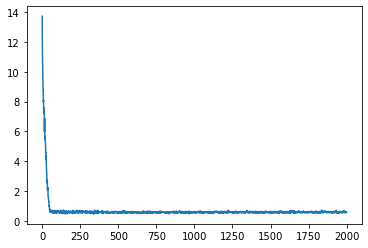

In [196]:
plt.plot(l2)

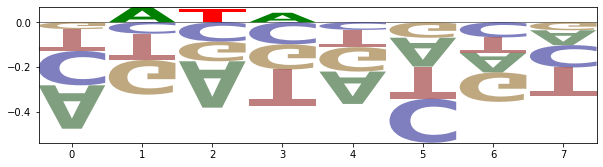

In [197]:
# print(np.exp(model.log_weight_1.squeeze().cpu().detach().numpy()))
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
#mb.tl.create_logo(net)
#plt.show()
#mb.tl.create_heatmap(net)
import logomaker
weights = model.conv_mono.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [198]:
from sklearn.metrics import r2_score

In [199]:
print('here...')

here...


### Check the quality of the predictions, across datasets

In [200]:
mononuc = torch.Tensor(train.dataset.mononuc).to(device)
dinuc = torch.Tensor(train.dataset.dinuc).to(device)
b = torch.Tensor(train.dataset.batch_one_hot).to(torch.int64)
y_true = torch.Tensor(train.dataset.target)
is_count_data = torch.Tensor(train.dataset.is_count_data)
inputs = (mononuc, dinuc, b)
y_pred = model(inputs).detach().numpy()

## This is step by step what forward at models.py is doing.
- Mind the shapes of X and embedding (b * emb) for final calculation. Swaps of that could be unintended and fatal.

In [201]:
x = inputs
mono, di, batch = x[0], x[1], x[2]
# print('input shape', mono.shape)

mono = torch.unsqueeze(mono, 1)
mono = mono.type(torch.float32)

# print('mono type', mono.dtype)
# mono = mono.type(torch.LongTensor)
mono = model.conv_mono(mono)

# print(di)
di = torch.unsqueeze(di, 1)
di = di.type(torch.float32)

di = model.conv_di(di)

# this is necessary but it needs to be rellocated
di = di.type(torch.LongTensor)

mono = torch.exp(mono)
di = torch.exp(di)
mono = mono.view(mono.shape[0], -1)  # Flatten tensor.
di = di.view(di.shape[0], -1)

if model.use_dinuc:
    x = torch.sum(mono, axis=1) + torch.sum(di, axis=1)
else:
    x = torch.sum(mono, axis=1)

x = x.view(-1)  # Flatten tensor.

# print('x in shape', x.shape)

emb = model.embedding
# print('emb shape', emb.weight.shape)
# print('batch shape', b.shape)

# b = emb(batch).sum(axis=1)
# b = b.view(-1)
b = emb.weight.T @ batch.T.type(torch.float32)

print('b shape (after emb)', b.shape)
x = torch.sum(x.reshape(x.shape[0], 1) * b.T, axis=1)
# b = b.view(-1)
# x * b
# print('x after emb', b.shape)



b shape (after emb) torch.Size([3, 294])


In [202]:
# batch.type(torch.float32) @ emb.weight 

In [203]:
import seaborn as sns
from sklearn.metrics import r2_score

In [204]:
model.embedding

Embedding(6, 3)

In [205]:
r2_score(y_true, y_pred)

-28.303366158704687

In [206]:
y_true[is_count_data == 1].shape, y_pred[is_count_data == 1].shape

(torch.Size([294]), (294,))

In [207]:
import seaborn as sns

In [212]:
# emb.weight.T

In [209]:
model.embedding.weight

Parameter containing:
tensor([[0.0636, 0.0636, 0.0636],
        [0.2948, 0.2948, 0.2948],
        [0.6409, 0.6409, 0.6409],
        [1.0201, 1.0201, 1.0201],
        [1.4134, 1.4134, 1.4134],
        [1.8488, 1.8488, 1.8488]], requires_grad=True)

<AxesSubplot:>

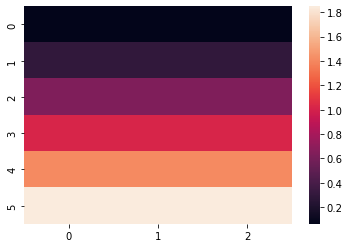

In [210]:
# Visualize the embedding layer
sns.heatmap(model.embedding.weight.detach().numpy())
plt.xlabel('dimension 1 (dataset)')
plt.ylabel('dimension 2 (latent')')

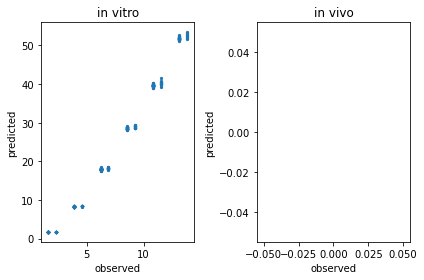

In [211]:
plt.subplot(1, 2, 1)
plt.scatter(y_true[is_count_data == 1], y_pred[is_count_data == 1], s=5)
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('in vitro')

plt.subplot(1, 2, 2)
plt.scatter(y_true[is_count_data == 0], y_pred[is_count_data == 0], s=5)
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('in vivo')
plt.tight_layout()

### II HT-SELEX with ChIP-seq (this does not work as intented)
- nan during loss calculation, possibly due to log on negative values

In [102]:
import mubind as mb
import numpy as np
import pandas as pd

import torch
import torch.optim as topti
import torch.utils.data as tdata

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


## II Only HT-SELEX batches

In [223]:
train, test = mb.tl.create_multi_data(n_chip=300, n_selex=300, n_batch_selex=1) # , n_selex=100)

max seqlen 200


### Using cooptf/screr (this will be deprecated and replace by bindome).

### If treating y data as log, the convergence gets to the GATA motif in small sequences.

In [224]:
train.dataset.target[train.dataset.is_count_data == 1] = np.log(train.dataset.target[train.dataset.is_count_data == 1])

In [225]:
pd.Series(train.dataset.batch).value_counts()

0_chip     591
0_selex    292
dtype: int64

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

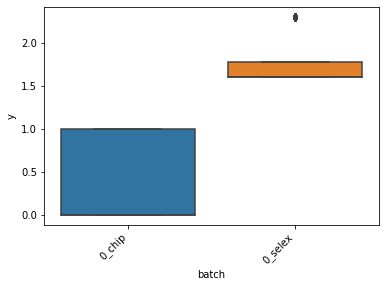

In [227]:
df = pd.DataFrame()
df['y'] = train.dataset.target
df['batch'] = np.array(train.dataset.batch)
sns.boxplot(data=df, x='batch', y='y')
plt.xticks(rotation=45, ha='right');

In [228]:
df.sort_values('y', ascending=False).head()

,y,batch
662,2.302585,0_selex
645,2.302585,0_selex
642,2.302585,0_selex
641,2.302585,0_selex
640,2.302585,0_selex


In [229]:
n_datasets = np.unique(df['batch']).shape[0]
n_latent = 3
print('# datasets', n_datasets)
print('# latent dimensions', n_latent)

# datasets 2
# latent dimensions 3


In [230]:
model = mb.models.DinucMulti(use_dinuc=True, n_datasets=n_datasets, n_latent=n_latent, w=8).to(device)
model.embedding.weight.data.uniform_(1, 1) # initialize weights as ones.
l2 = []

In [231]:
train.dataset

In [232]:
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = mb.tl.MultiDatasetLoss()
l2 += mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=2000, log_each=100)

Epoch:  1, Loss: 1178.080
Epoch: 101, Loss: nan


KeyboardInterrupt: 

In [233]:
model.load_state_dict(model.best_model_state)

<All keys matched successfully>

In [234]:
mononuc = torch.Tensor(train.dataset.mononuc) # .type(torch.float32)
dinuc = torch.Tensor(train.dataset.dinuc) # .type(float32)
b = torch.Tensor(train.dataset.batch_one_hot)
y_true = torch.Tensor(train.dataset.target)
is_count_data = torch.Tensor(train.dataset.is_count_data)
inputs = (mononuc, dinuc, b)
y_pred = torch.Tensor(model(inputs).detach().numpy())

In [235]:
y_pred.shape, y_pred[y_pred > 0].shape, y_pred[y_pred < 0].shape

(torch.Size([883]), torch.Size([883]), torch.Size([0]))

In [236]:
loss = torch.abs(y_true[is_count_data == 1] - y_pred[is_count_data == 1]*torch.log(y_true[is_count_data == 1]))
poisson_loss = torch.mean(loss)
print(poisson_loss)
# print('BCE')
# print(b)
# print(b.shape)
# print(targets[is_count_data == 0])
# print(targets[is_count_data == 0].shape)


tensor(2.8714)


In [237]:
torch.mean(torch.abs((y_true[is_count_data == 1] - y_pred[is_count_data == 1] * np.log(y_true[is_count_data == 1]))))

tensor(2.8714)

In [238]:
print('checking that the values are similar after training (using MultiDatasetLoss during training')
l_poisson = mb.tl.PoissonLoss()
%time l_poisson(torch.Tensor(y_pred[is_count_data == 1]), y_true[is_count_data == 1], is_count_data)


checking that the values are similar after training (using MultiDatasetLoss during training
CPU times: user 8.57 ms, sys: 88 µs, total: 8.66 ms
Wall time: 367 µs


tensor(4.4734)

In [239]:
l_multi = mb.tl.MultiDatasetLoss()
%time l_multi(torch.Tensor(y_pred), y_true, is_count_data)

CPU times: user 8.69 ms, sys: 0 ns, total: 8.69 ms
Wall time: 747 µs


tensor(54.5580)

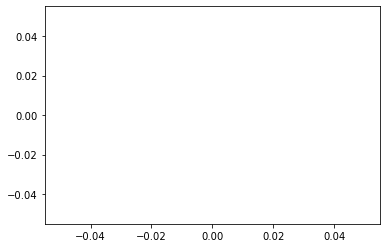

In [240]:
plt.plot(l2)

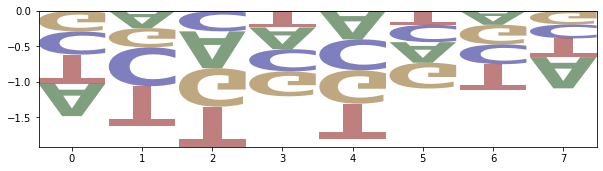

In [241]:
# print(np.exp(model.log_weight_1.squeeze().cpu().detach().numpy()))
# print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
#mb.tl.create_logo(net)
#plt.show()
#mb.tl.create_heatmap(net)
import logomaker
weights = model.conv_mono.weight
weights = weights.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
crp_logo = logomaker.Logo(weights.T, shade_below=.5, fade_below=.5)

In [242]:
from sklearn.metrics import r2_score

In [243]:
print('here...')

here...


### Check the quality of the predictions, across datasets

In [244]:
mononuc = torch.Tensor(train.dataset.mononuc).to(device)
dinuc = torch.Tensor(train.dataset.dinuc).to(device)
b = torch.Tensor(train.dataset.batch_one_hot).to(torch.int64)
y_true = torch.Tensor(train.dataset.target)
is_count_data = torch.Tensor(train.dataset.is_count_data)
inputs = (mononuc, dinuc, b)
y_pred = model(inputs).detach().numpy()

## This is step by step what forward at models.py is doing.
- Mind the shapes of X and embedding (b * emb) for final calculation. Swaps of that could be unintended and fatal.

In [245]:
x = inputs
mono, di, batch = x[0], x[1], x[2]
# print('input shape', mono.shape)

mono = torch.unsqueeze(mono, 1)
mono = mono.type(torch.float32)

# print('mono type', mono.dtype)
# mono = mono.type(torch.LongTensor)
mono = model.conv_mono(mono)

# print(di)
di = torch.unsqueeze(di, 1)
di = di.type(torch.float32)

di = model.conv_di(di)

# this is necessary but it needs to be rellocated
di = di.type(torch.LongTensor)

mono = torch.exp(mono)
di = torch.exp(di)
mono = mono.view(mono.shape[0], -1)  # Flatten tensor.
di = di.view(di.shape[0], -1)

if model.use_dinuc:
    x = torch.sum(mono, axis=1) + torch.sum(di, axis=1)
else:
    x = torch.sum(mono, axis=1)

x = x.view(-1)  # Flatten tensor.

# print('x in shape', x.shape)

emb = model.embedding
# print('emb shape', emb.weight.shape)
# print('batch shape', b.shape)

# b = emb(batch).sum(axis=1)
# b = b.view(-1)
b = emb.weight.T @ batch.T.type(torch.float32)

print('b shape (after emb)', b.shape)
x = torch.sum(x.reshape(x.shape[0], 1) * b.T, axis=1)
# b = b.view(-1)
# x * b
# print('x after emb', b.shape)



b shape (after emb) torch.Size([3, 883])


In [246]:
# batch.type(torch.float32) @ emb.weight 

In [247]:
import seaborn as sns
from sklearn.metrics import r2_score

In [248]:
model.embedding

Embedding(2, 3)

In [249]:
r2_score(y_true, y_pred)

-22233.6044146996

In [250]:
y_true[is_count_data == 1].shape, y_pred[is_count_data == 1].shape

(torch.Size([292]), (292,))

In [251]:
import seaborn as sns

In [252]:
# emb.weight.T

In [253]:
model.embedding.weight

Parameter containing:
tensor([[0.2244, 0.2244, 0.2244],
        [0.0073, 0.0073, 0.0073]], requires_grad=True)

<AxesSubplot:>

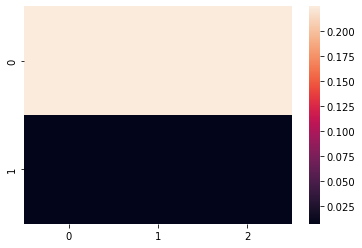

In [254]:
sns.heatmap(model.embedding.weight.detach().numpy())

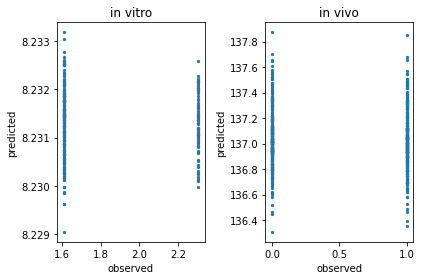

In [255]:
plt.subplot(1, 2, 1)
plt.scatter(y_true[is_count_data == 1], y_pred[is_count_data == 1], s=5)
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('in vitro')

plt.subplot(1, 2, 2)
plt.scatter(y_true[is_count_data == 0], y_pred[is_count_data == 0], s=5)
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title('in vivo')
plt.tight_layout()